In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for age estimation stochastic process

This notebook shows how to train and sample from a Neural Process for age estimation

We select the FG-net, each person as a batch. In each batch, there are 18 persons.


In [2]:
from datasets import FaceFeatureData

# Create dataset
num_of_people = 3
num_of_images=18
dataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images)

#82 different people(batch_num)
#18 different images each people(batch_size)
#x_dim = 2048


### Build Neural Process

In [3]:
from neural_process import NeuralProcess

x_dim = 2048
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Train Neural Process


Epoch: 0, Avg_loss: 10846.663513183594
Epoch: 1, Avg_loss: 98.95793151855469
Epoch: 2, Avg_loss: 98.63635762532552
Epoch: 3, Avg_loss: 98.37577311197917
Epoch: 4, Avg_loss: 97.50936126708984
Epoch: 5, Avg_loss: 96.99312082926433
Epoch: 6, Avg_loss: 97.3414815266927
Epoch: 7, Avg_loss: 96.20968119303386
Epoch: 8, Avg_loss: 95.0952631632487
Epoch: 9, Avg_loss: 94.89576466878255
Epoch: 10, Avg_loss: 94.31024932861328
Epoch: 11, Avg_loss: 94.21786244710286
Epoch: 12, Avg_loss: 93.51469167073567
Epoch: 13, Avg_loss: 93.19683074951172
Epoch: 14, Avg_loss: 92.5988998413086
Epoch: 15, Avg_loss: 92.0246810913086
Epoch: 16, Avg_loss: 91.26009368896484
Epoch: 17, Avg_loss: 91.20225016276042
Epoch: 18, Avg_loss: 90.40600077311198
Epoch: 19, Avg_loss: 90.17312622070312
Epoch: 20, Avg_loss: 90.04954528808594
Epoch: 21, Avg_loss: 89.39864095052083
Epoch: 22, Avg_loss: 88.80863698323567
Epoch: 23, Avg_loss: 88.60177866617839
Epoch: 24, Avg_loss: 88.12396494547527
Epoch: 25, Avg_loss: 87.63652038574219

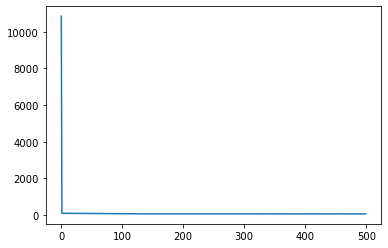

In [4]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 1
num_context = 17
num_target = 1

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 500)
#save model
torch.save(neuralprocess.state_dict(), r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\pretrained.ckpt')
plt.plot(range(len(np_trainer.epoch_loss_history)),np_trainer.epoch_loss_history)
plt.show()


### predict without context



In [5]:
for batch in data_loader:
    break
x_target, y_target = batch
print(y_target)
# print(x_target)
# print(x_target.size())
for i in range(10):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    print(mu.detach())



tensor([[[51.],
         [18.],
         [47.],
         [25.],
         [20.],
         [18.],
         [25.],
         [35.],
         [58.],
         [20.],
         [23.],
         [35.],
         [38.],
         [49.],
         [58.],
         [60.],
         [49.],
         [61.]]])
tensor([[[35.3414],
         [14.7679],
         [44.8555],
         [13.2495],
         [17.1841],
         [15.1566],
         [17.0036],
         [25.5948],
         [48.5223],
         [17.3840],
         [17.5946],
         [42.2661],
         [21.3527],
         [22.4635],
         [55.8299],
         [40.9011],
         [31.9981],
         [34.2574]]])
tensor([[[38.0105],
         [17.4563],
         [47.5233],
         [15.9462],
         [19.8717],
         [17.8341],
         [19.6939],
         [28.3013],
         [51.1490],
         [20.0718],
         [20.2870],
         [44.9462],
         [24.0530],
         [25.1481],
         [58.3870],
         [43.4635],
         [34.6911],
        

### predict with context


In [6]:
from utils import context_target_split

for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)
neuralprocess.training = False
from datasets import FaceFeatureTestData

testDataset = FaceFeatureTestData()
testData_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

for x_target, y_target in testData_loader:
    avg_mu = 0
    for i in range(10):
        p_y_pred = neuralprocess(x_context, y_context, x_target)
        # Extract mean of distribution
        mu = p_y_pred.loc.detach()
        avg_mu += mu
    print('prediceted value: ')
    print(avg_mu / 10)
    print('target value:')
    print(y_target)


prediceted value: 
tensor([[[72.5631],
         [40.2197],
         [25.6759],
         [22.1763],
         [41.0048],
         [27.4786],
         [23.6717],
         [31.0153],
         [36.3050],
         [19.4988],
         [24.4813],
         [34.2493],
         [21.5662],
         [43.9641],
         [50.2672],
         [45.7708],
         [18.1740],
         [26.2333]]])
target value:
tensor([[[63.],
         [62.],
         [48.],
         [28.],
         [53.],
         [30.],
         [26.],
         [53.],
         [30.],
         [19.],
         [21.],
         [30.],
         [30.],
         [37.],
         [51.],
         [53.],
         [28.],
         [40.]]])


In [7]:
from utils import context_target_split

for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

#load model
testNeuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
testNeuralprocess.load_state_dict(torch.load(r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\pretrained.ckpt'))
testNeuralprocess.training = False

from datasets import FaceFeatureTestData

testDataset = FaceFeatureTestData()
testData_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)
for x_target, y_target in testData_loader:
    avg_mu = 0
    for i in range(10):
        p_y_pred = testNeuralprocess(x_context, y_context, x_target)
        # Extract mean of distribution
        mu = p_y_pred.loc.detach()
        avg_mu += mu
    print('prediceted value: ')
    print(avg_mu / 10)
    print('target value:')
    print(y_target)



prediceted value: 
tensor([[[72.5237],
         [40.1795],
         [25.6178],
         [22.1195],
         [40.9648],
         [27.4218],
         [23.6144],
         [30.9737],
         [36.2488],
         [19.4426],
         [24.4230],
         [34.1927],
         [21.5088],
         [43.9165],
         [50.2277],
         [45.7309],
         [18.1189],
         [26.1737]]])
target value:
tensor([[[63.],
         [62.],
         [48.],
         [28.],
         [53.],
         [30.],
         [26.],
         [53.],
         [30.],
         [19.],
         [21.],
         [30.],
         [30.],
         [37.],
         [51.],
         [53.],
         [28.],
         [40.]]])
